In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
from my_utils import *

Prepare Normal Data and Abnormal Data

In [ ]:
# 8_train.csv + 2_test.csv equals the whole dataset
data_all = pd.concat(
    [
        pd.read_csv("train_test_data/8_train.csv"),
        pd.read_csv("train_test_data/2_test.csv"),
    ],
    axis=0
)

In [ ]:
"""
The strictest case:
    Normal - recall, precision, and accuracy all equals 1
"""

normal_rep_1 = data_all[
    (data_all["recall"] == 1)
    & (data_all["precision"] == 1)
    & (data_all["accuracy"] == 1)
]

print(f"The resulted normal representation has the shape: {normal_rep_1.shape}")

# The resulted normal representation only has 3276 samples, less than 1/10 of the total sample.
# Now slightly loosen the criteria to observe changes.

In [ ]:
"""
The less strict case:
    Normal - recall, precision, and accuracy all >= a propriate threshold
"""

threshold = 0.7
normal_rep_2 = data_all[
    (data_all["recall"] >= threshold)
    & (data_all["precision"] >= threshold)
    & (data_all["accuracy"] >= threshold)
]

print(f"The resulted normal representation has the shape: {normal_rep_2.shape}")

# Threshold = 0.9, 3305 samples
# Threshold = 0.8, 4340 samples
# Threshold = 0.7, 6302 samples

# It might not be a good idea to decrease threshold for more samples

In [ ]:
"""
The one metric cases:
    Normal - recall /precision / or accuracy equals one or is lager than a threshold
"""
normal_rep_recall = data_all[
    data_all["recall"] >= 0.6
]

print(f"The resulted normal representation has the shape: {normal_rep_recall.shape}") # -> 11237

normal_rep_precision = data_all[
    data_all["precision"] == 1
]

print(f"The resulted normal representation has the shape: {normal_rep_precision.shape}") # -> 22454

normal_rep_accuracy = data_all[
    data_all["accuracy"] >= 0.8
]

print(f"The resulted normal representation has the shape: {normal_rep_accuracy.shape}") # -> 15818

# A lower threshold was given to recall, to allow more samples.

In [ ]:
'''
To allow comparison, use a same set of samples as anormaly data.
The goal is to study which normal setup is better.
The anormal data is in the strictest sense.
'''

abnormal_rep = data_all[
    (data_all["recall"] < 0.3)
    | (data_all["precision"] < 0.3)
    | (data_all["accuracy"] < 0.3)
]

print(f"The resulted abnormal representation has the shape: {abnormal_rep.shape}") # -> 11911

Define Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, input_size // 2),
            nn.BatchNorm1d(input_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_size // 2, input_size // 4),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(input_size // 4, input_size // 2),
            nn.ReLU(),
            nn.Linear(input_size // 2, input_size)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Train on Normal Data

In [149]:
# Select features
features = [
    # "country_code",
    "weather",
    # "road_type",
    # "road_condition",
    "time_of_day",
    # "num_vehicles",
    # "longitude",
    # "latitude",
    "solar_angle_elevation",
    # "focal_length_x",
    # "focal_length_y",
    # "principle_point_x",
    # "principle_point_y",
    # "camera_pose_x",
    # "camera_pose_y",
    # "camera_pose_z",
    # "camera_pose_yaw",
    # "camera_pose_pitch",
    # "camera_pose_roll",
    # "horizontal_fov",
    # "vertical_fov",
    # "ego_pose_x",
    # "ego_pose_y",
    # "ego_pose_z",
    # "ego_pose_yaw",
    # "ego_pose_pitch",
    # "ego_pose_roll",
    # "speed_var",
    # "mean_jerk",
    # "max_jerk",
    # "st_jerk",
    # "mean_angular_acc",
    # "max_angular_acc",
    # "st_angular_acc",
    # "mean_lateral_acc",
    # "max_lateral_acc",
    # "st_lateral_acc",
    "luminance",
    "contrast",
    "saturation",
    "sharpness",
    "temperature",
    "edge_density",
    "entropy",
]

model = Autoencoder(input_size=len(features))
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# ReduceLROnPlateau scheduler setup
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, verbose=True
)

# DataLoader for batching
# normal_data = normal_rep_1[features].values
# normal_data = normal_rep_2[features].values
# normal_data = normal_rep_recall[features].values
# normal_data = normal_rep_precision[features].values
normal_data = normal_rep_accuracy[features].values
normal_tensor = torch.tensor(normal_data, dtype=torch.float32)
anomalous_tensor = torch.tensor(abnormal_rep[features].values, dtype=torch.float32)

# With standard scaler
# scaler = StandardScaler()
# normal_tensor = torch.tensor(
#     scaler.fit_transform(normal_data), dtype=torch.float32
# )
# anomalous_tensor = torch.tensor(
#     scaler.fit_transform(abnormal_rep[features].values), dtype=torch.float32
# )

train_loader = DataLoader(TensorDataset(normal_tensor), batch_size=32, shuffle=True)

# Training loop
for epoch in range(100):
    total_loss = 0
    for batch in train_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

# print("Training complete.")
# torch.save(model.state_dict(), "outputs/models/ae_model.pth")
# print("Model saved to output/models/ae_model.pth")

/Users/xw/Desktop/Personal/05_Courses/15_Risk Lab/04_Data Processing/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Loss = 21.6635
Epoch 2: Loss = 21.3229
Epoch 3: Loss = 20.0295
Epoch 4: Loss = 19.1982
Epoch 5: Loss = 19.0040
Epoch 6: Loss = 19.0424
Epoch 7: Loss = 18.7173
Epoch 8: Loss = 18.6336
Epoch 9: Loss = 18.5867
Epoch 10: Loss = 18.5311
Epoch 11: Loss = 18.5242
Epoch 12: Loss = 18.5176
Epoch 13: Loss = 18.5446
Epoch 14: Loss = 18.4984
Epoch 15: Loss = 18.4603
Epoch 16: Loss = 18.4670
Epoch 17: Loss = 18.4384
Epoch 18: Loss = 18.4788
Epoch 19: Loss = 18.4338
Epoch 20: Loss = 18.4431
Epoch 21: Loss = 18.4587
Epoch 22: Loss = 18.4730
Epoch 23: Loss = 18.4526
Epoch 24: Loss = 18.4305
Epoch 25: Loss = 18.4452
Epoch 26: Loss = 18.4707
Epoch 27: Loss = 18.4671
Epoch 28: Loss = 18.4876
Epoch 29: Loss = 18.4470
Epoch 30: Loss = 18.4577
Epoch 31: Loss = 18.4481
Epoch 32: Loss = 18.4473
Epoch 33: Loss = 18.4674
Epoch 34: Loss = 18.4174
Epoch 35: Loss = 18.4435
Epoch 36: Loss = 18.4985
Epoch 37: Loss = 18.4832
Epoch 38: Loss = 18.4661
Epoch 39: Loss = 18.4195
Epoch 40: Loss = 18.4519
Epoch 41:

Evaluate and Detect Anormalies

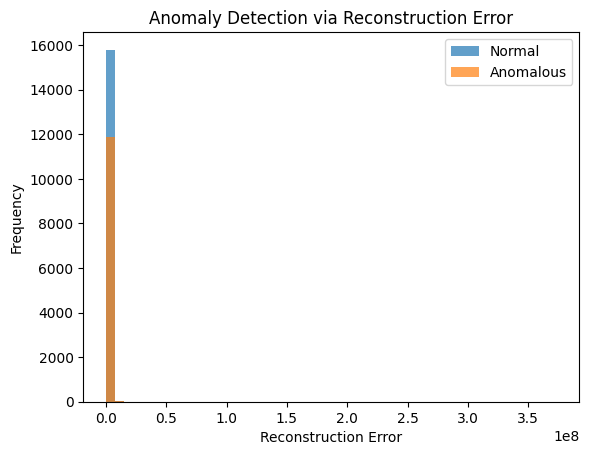

In [150]:
def get_reconstruction_errors(data):
    with torch.no_grad():
        reconstructed = model(data)
        errors = torch.mean((data - reconstructed) ** 2, dim=1)
    return errors

# Get errors for both datasets
normal_errors = get_reconstruction_errors(normal_tensor)
anomalous_errors = get_reconstruction_errors(anomalous_tensor)

# Visualize
plt.hist(normal_errors.numpy(), bins=50, alpha=0.7, label="Normal")
plt.hist(anomalous_errors.numpy(), bins=50, alpha=0.7, label="Anomalous")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Anomaly Detection via Reconstruction Error")
plt.show()

Set Threshold to Make Predictions

In [151]:
# Simple threshold based on 95th percentile of normal errors
threshold = np.percentile(normal_errors.numpy(), 95)

# Predictions
anomaly_flags = anomalous_errors > threshold
print(f"Detected anomalies: {anomaly_flags.sum().item()} out of {len(anomalous_tensor)}")

Detected anomalies: 837 out of 11911


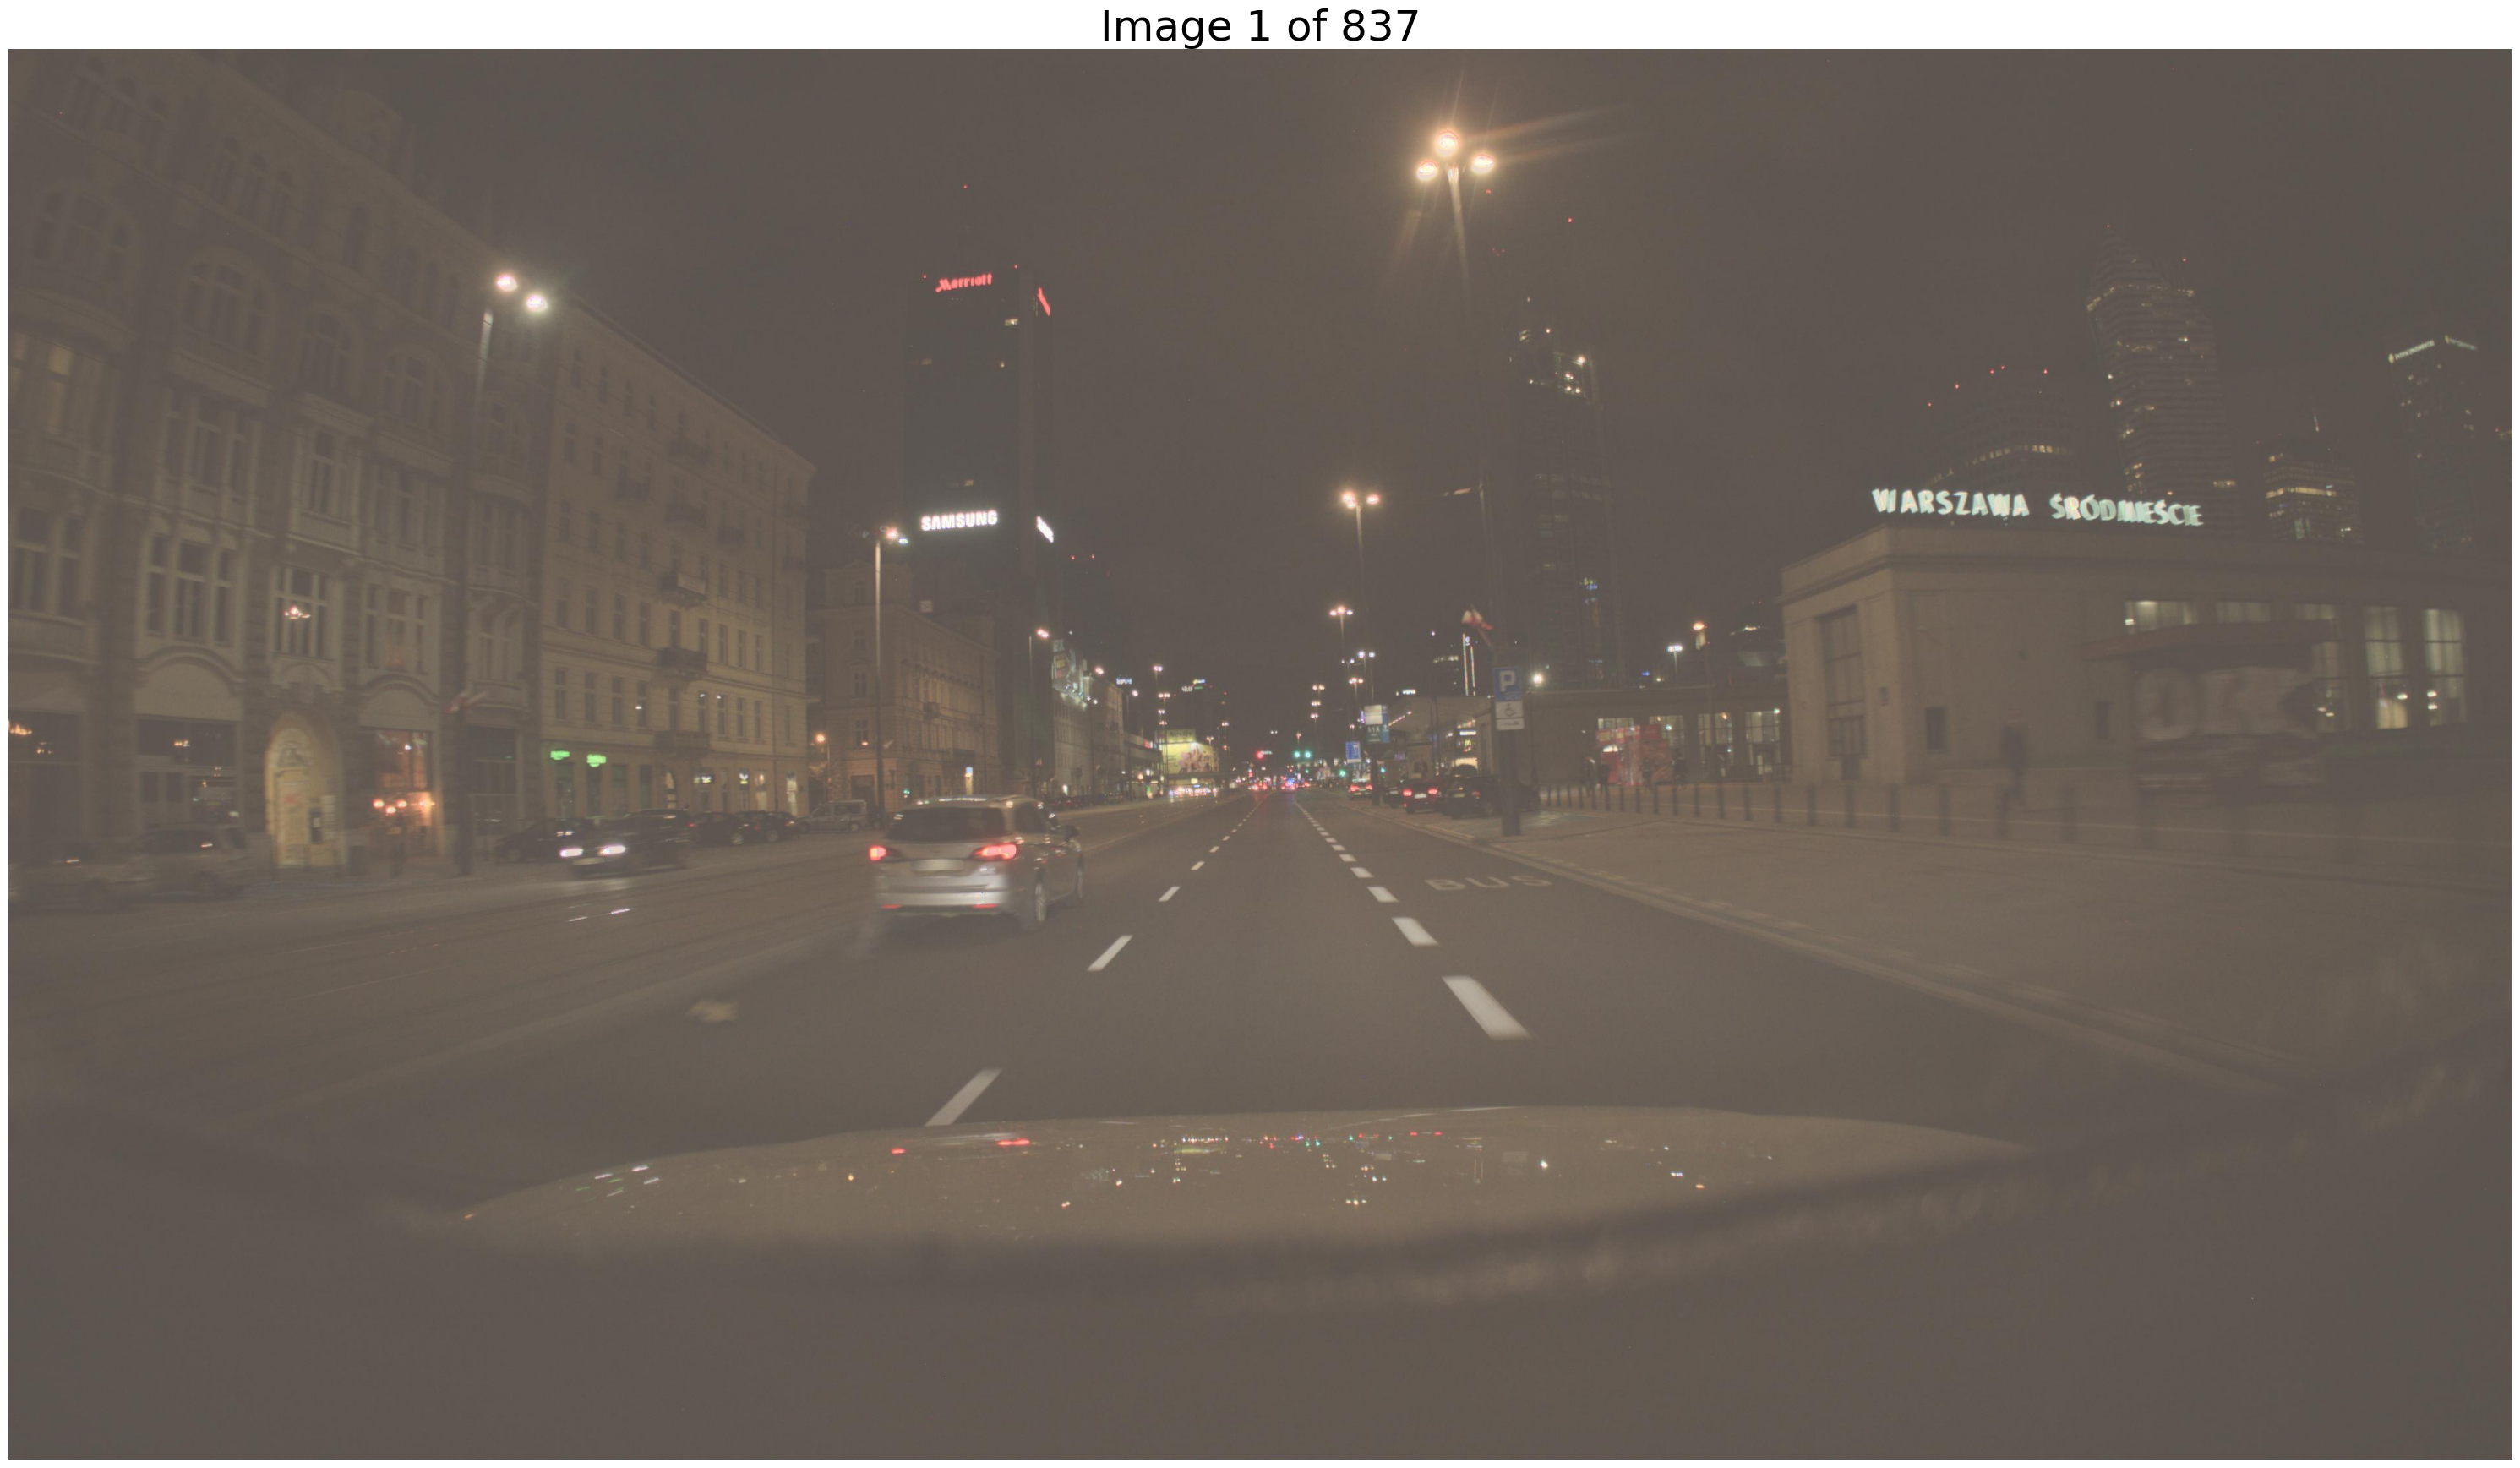

In [152]:
# Navigrate through the images identified as abnormal
img_ids = abnormal_rep[anomaly_flags.numpy()]["image_id"].values
img_ids = [f"{img_id:06d}" for img_id in img_ids]

img_folders = [
    os.path.join("single_frames_img", img_id, "camera_front_blur") for img_id in img_ids
]

img_paths = [os.path.join(img_fd, os.listdir(img_fd)[0]) for img_fd in img_folders]

navigate_images(img_paths) 